# DAE debugging

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/scratch_net/biwidl319/jbermeo/logs/brain/tta/debugging/dae_only/3_08/lr_1em3_grad_acc_1x1_conv_norm_dae_and_ddpm_script_juan_testset_v2/dice_scores_hcp_t2_per_step_start_vol_0_stop_vol_20.csv',
                 index_col=0)

<Axes: >

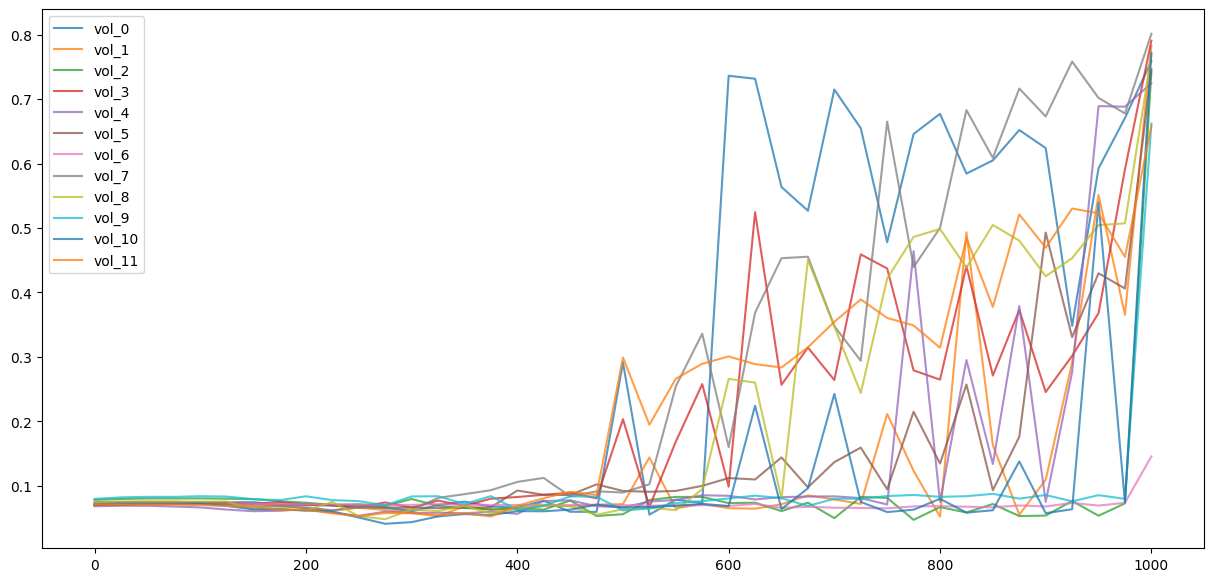

In [8]:
# Make a line plot of all columns of figsize 15, 7
df.plot(kind='line', figsize=(15, 7), alpha=0.75)

<Axes: >

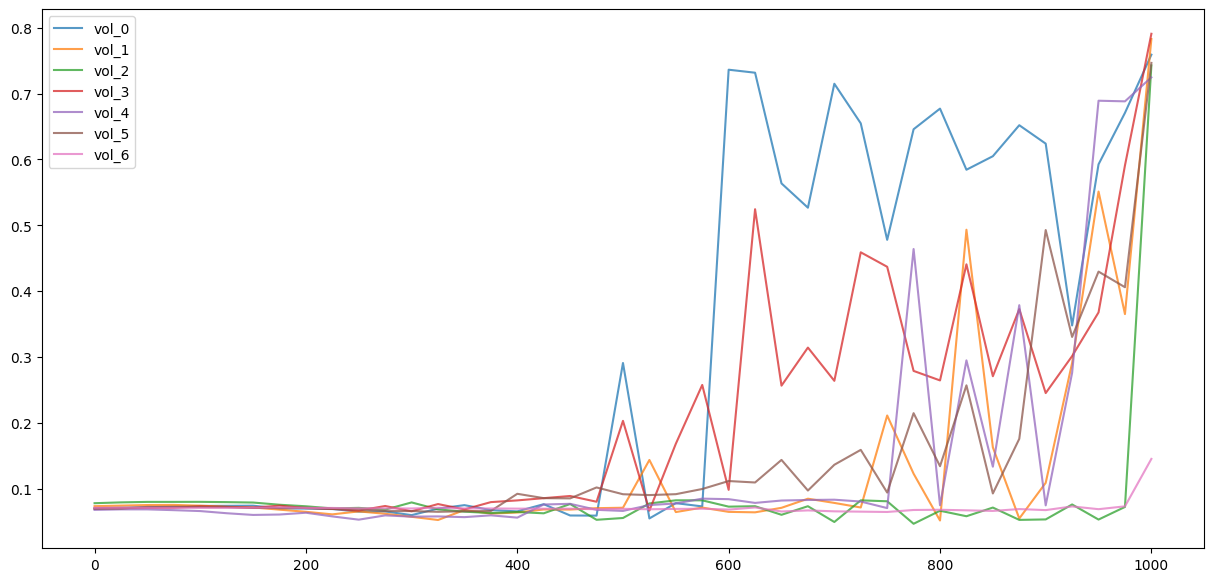

In [11]:
# Make a line plot of all columns of figsize 15, 7
vols = [0, 1, 2, 3, 4, 5 , 6]
cols = [col for col in df.columns if int(col.split('_')[-1]) in vols]
df[cols].plot(kind='line', figsize=(15, 7), alpha=0.75)

# Older random stuff

In [6]:
import os
import sys
import glob

sys.path.append(os.path.join(".."))
from tta_uia_segmentation.src.preprocessing.utils import get_filepaths_raw, get_filepaths_preprocessed

In [7]:
a = get_filepaths_preprocessed(path_to_dir="/scratch_net/biwidl319/jbermeo/data/preprocessed/1_resampled/USZ")

In [8]:
len(a)

62

## Other random stuff

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
a = torch.ones((1, 256, 1, 256, 256))

In [8]:
dl = DataLoader(
        TensorDataset(a.squeeze(0)),
        batch_size=4,
        shuffle=False,
        num_workers=0,
        drop_last=False,
    )

next(iter(dl))[0].shape
    

torch.Size([4, 1, 256, 256])

## Check distribution of field of views on resample images

In [51]:
a = get_filepaths(preprocessed=True, path_to_dir='/scratch_net/biwidl319/jbermeo/data/preprocessed/1_resampled/Lausanne', every_scan_has_seg=False)

In [53]:
shapes = list()
for idx, img_fps in a.items():
    img = nib.load(img_fps['tof'])
    shapes.append(img.shape)
    
    # print pixel spacing
    print(img.header.get_zooms())
    

In [33]:
# USZ
np.median(np.array(shapes), axis=0)

array([566., 666., 181.])

In [39]:
# ADAM
np.median(np.array(shapes), axis=0)

array([666., 666., 116.])

In [54]:
# Lausanne
np.median(np.array(shapes), axis=0)

array([570., 700., 166.])

(array([ 3.,  1., 18.,  7.,  9.,  1.,  0.,  0.,  7., 10.]),
 array([499. , 519.1, 539.2, 559.3, 579.4, 599.5, 619.6, 639.7, 659.8,
        679.9, 700. ]),
 <BarContainer object of 10 artists>)

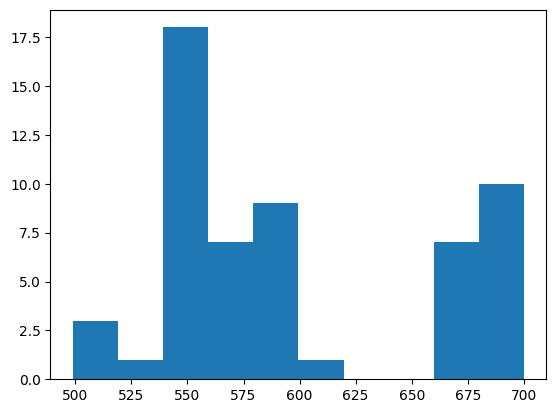

In [60]:
# plot histogram
import matplotlib.pyplot as plt
plt.hist(np.array(shapes)[:, 0],)

(array([ 1.,  0.,  0.,  3.,  0.,  0., 39.,  0., 12.,  1.]),
 array([600. , 616.6, 633.2, 649.8, 666.4, 683. , 699.6, 716.2, 732.8,
        749.4, 766. ]),
 <BarContainer object of 10 artists>)

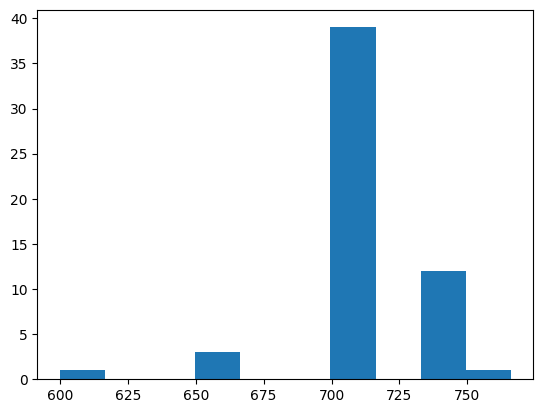

In [62]:
plt.hist(np.array(shapes)[:, 1])

## Resampling and reszing with nibabel

In [39]:
import h5py
import numpy as np
import nibabel as nib
import nibabel.processing as nibp
import matplotlib.pyplot as plt

In [40]:
ds = h5py.File('/scratch_net/biwidl319/jbermeo/data/preprocessed/UIA_segmentation/USZ.h5', 'r')

(0.6, 0.3, 0.6)


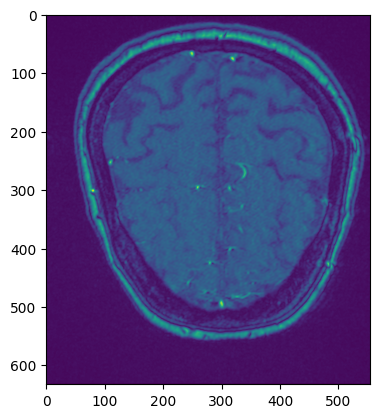

In [41]:
img_group = ds['data']['10896074_BRE_AComm_ICA']

image = img_group['tof'][:][0]
labels = img_group['seg'][:][0]
px = img_group['px'][()]
py = img_group['py'][()]
pz = img_group['pz'][()]


orig_voxel_size = (pz, py, pz)  
print(orig_voxel_size)
plt.imshow(image[60, :, :])

In [45]:
orig_voxel_size

(0.6, 0.3, 0.6)

In [43]:
# Create a nib image object with the original voxel size
affine = [
    [orig_voxel_size[0], 0, 0, 0],
    [0, orig_voxel_size[1], 0, 0], 
    [0, 0, orig_voxel_size[2], 0], 
    [0, 0, 0, 1]]
img = nib.Nifti1Image(image, affine)
img.header.set_zooms(orig_voxel_size)


In [157]:
%%timeit
a = nibp.conform(img, (150, 600, 460), voxel_size=(0.7, 0.3, 0.3), order=3)

10.8 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
1 / np.array([0.25, 1, 1])

array([4., 1., 1.])

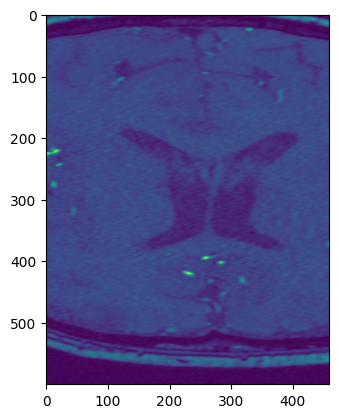

In [44]:
img = nibp.conform(img, (150, 600, 460), voxel_size=(0.7, 0.3, 0.3), order=3)  
plt.imshow(img.get_fdata()[60, :, :])

In [150]:
img.shape

(150, 600, 460)

### Check how the largest images look after cropping

In [23]:
target_size = [160, 560, 640]
target_resolution = (0.6, 0.3, 0.3)

(0.6, 0.3, 0.3)


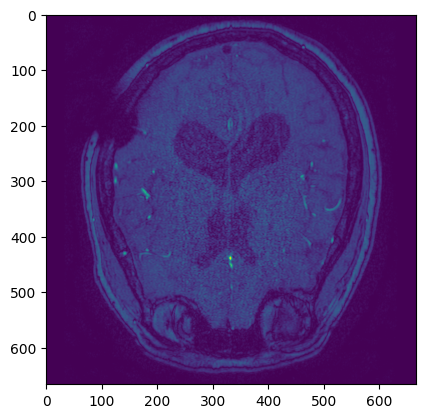

In [33]:
#img_group = ds['data']['10896074_BRE_AComm_ICA']
img_group = ds['data']['10147148-AComm-NEW']

image = img_group['tof'][:][0]
labels = img_group['seg'][:][0]
px = img_group['px'][()]
py = img_group['py'][()]
pz = img_group['pz'][()]


orig_voxel_size = (pz, px, py)  
print(orig_voxel_size)
plt.imshow(image[60, :, :])

In [34]:
affine = [
    [orig_voxel_size[0], 0, 0, 0],
    [0, orig_voxel_size[1], 0, 0], 
    [0, 0, orig_voxel_size[2], 0], 
    [0, 0, 0, 1]]
img = nib.Nifti1Image(image, affine)
img.header.set_zooms(orig_voxel_size)

In [35]:
img_cropped = nibp.conform(img, target_size, voxel_size=target_resolution, order=3)  


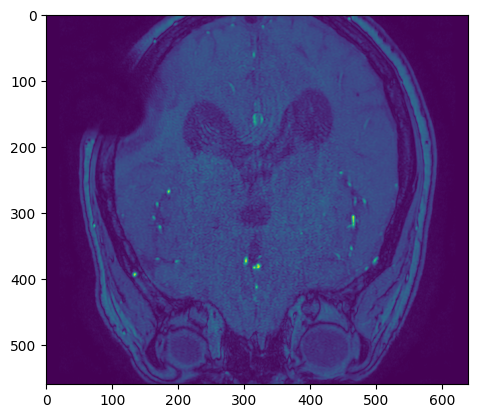

In [36]:
plt.imshow(img_cropped.get_fdata()[60, :, :])

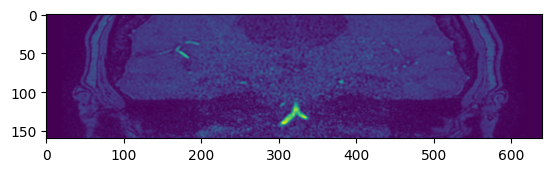

In [37]:
plt.imshow(img_cropped.get_fdata()[:, 275, :])

In [38]:
nib.save(img_cropped, f'largest_fov_largest_z_size_{target_size}_res_{target_resolution}_10147148-AComm-NEW_tof.nii.gz')

### Check how the dataset class is working

In [1]:
import sys
sys.path.append('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/tta_uia_segmentation/src')

In [2]:
from dataset.dataset_h5 import DatasetH5
import matplotlib.pyplot as plt
import yaml
from pprint import pprint

In [3]:
config = yaml.load(open('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/training_hcp_t1w.yaml', 'r'),
          Loader=yaml.FullLoader)

In [4]:
pprint(config['segmentation'])

{'augmentation': {'alpha': 1000,
                  'brightness_max': 0.1,
                  'brightness_min': 0.0,
                  'da_ratio': 0.25,
                  'gamma_max': 2.0,
                  'gamma_min': 0.5,
                  'noise_mean': 0.0,
                  'noise_std': 0.1,
                  'rot_max': 10,
                  'rot_min': -10,
                  'scale_max': 1.1,
                  'scale_min': 0.9,
                  'sigma': 20,
                  'trans_max': 10,
                  'trans_min': -10},
 'batch_size': 16,
 'bg_suppression_opts': {'bg_value': -0.5,
                         'bg_value_max': 1,
                         'bg_value_min': -0.5,
                         'hole_filling': True,
                         'mask_source': 'thresholding',
                         'thresholding': 'otsu',
                         'type': 'fixed_value'},
 'dataset': 'hcp_t1',
 'epochs': 150,
 'image_size': [1, 256, 256],
 'learning_rate': 0.001,
 'logdir': '/sc

In [5]:
bg_suppression_opts = config['segmentation']['bg_suppression_opts']
pprint(bg_suppression_opts)

{'bg_value': -0.5,
 'bg_value_max': 1,
 'bg_value_min': -0.5,
 'hole_filling': True,
 'mask_source': 'thresholding',
 'thresholding': 'otsu',
 'type': 'fixed_value'}


In [6]:
bg_suppression_opts['hole_filling'] = False
bg_suppression_opts['mask_source'] = 'ground_truth'

In [4]:
data_dir_path = '../../data/'
bias_corrected_data_dir_path = os.path.join(data_dir_path, 'preprocessed/0_bias_corrected/USZ')
raw_data_dir_path = os.path.join(data_dir_path, 'raw/USZ')

In [24]:
fps = glob.glob(os.path.join(bias_corrected_data_dir_path, '*'))

In [25]:
fps

['../../data/preprocessed/0_bias_corrected/USZ/10107525-MCA-new-Colors',
 '../../data/preprocessed/0_bias_corrected/USZ/10811755_CC_AComm_NEW',
 '../../data/preprocessed/0_bias_corrected/USZ/60213089-MCA-ICA-NEW',
 '../../data/preprocessed/0_bias_corrected/USZ/10764179-MCA-NEW_DONE',
 '../../data/preprocessed/0_bias_corrected/USZ/11096773_IB_PComm',
 '../../data/preprocessed/0_bias_corrected/USZ/60201588-MCA-NEW_DONE',
 '../../data/preprocessed/0_bias_corrected/USZ/10731286-ICA-links-NEW',
 '../../data/preprocessed/0_bias_corrected/USZ/11047954_LM_Pericallosa',
 '../../data/preprocessed/0_bias_corrected/USZ/10104830_ZG_ComplexICA_Checked',
 '../../data/preprocessed/0_bias_corrected/USZ/10299485_BMM_AComm_MCA_Checked',
 '../../data/preprocessed/0_bias_corrected/USZ/10266790_CL_ICA_Checked',
 '../../data/preprocessed/0_bias_corrected/USZ/10599468-AComm-new',
 '../../data/preprocessed/0_bias_corrected/USZ/10019209_EK_MCA_Checked',
 '../../data/preprocessed/0_bias_corrected/USZ/10986737_SH

In [28]:
missing_seg_mask = [ ]
for fp in fps:
    scans = glob.glob(os.path.join(fp, '*.nii.gz'))
    
    if len(scans) == 1:
        missing_seg_mask.append(fp)
        
    elif len(scans) == 0:
        print(f'{fp} has no scans at all')

In [29]:
missing_seg_mask

[]

In [5]:
for a in ds:
    break

(1, 111, 566, 566) (1, 111, 566, 566) (1, 111, 566, 566)


RuntimeError: sequence argument must have length equal to input rank

In [70]:
a[4]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

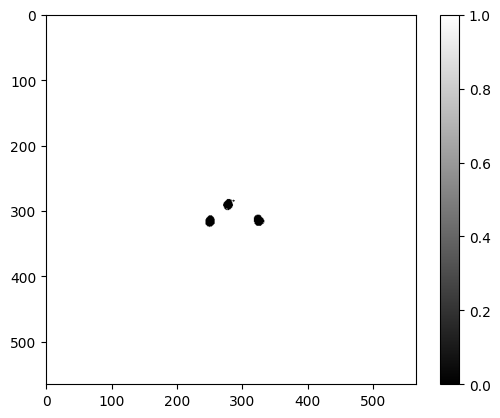

In [71]:
# Print image with a color bar showing the pixel values
plt.imshow(a[4][60, :, :], cmap='gray', vmin=0, vmax=1)
plt.colorbar()